## 1. Вступление

**Cookie Cats** - это чрезвычайно популярная мобильная головоломка, разработанная компанией **Tactile Entertainment**. Это классическая игра в стиле «соедини три», где игрок должен соединять плитки одного цвета, чтобы очистить доску и выиграть уровень.


Но где следует разместить ворота?


Изначально первые ворота были размещены на 30 уровне, но в этой записной книжке мы собираемся проанализировать AB-тест, где мы переместили первые ворота в игре Cookie Cats с 30 уровня на 40 уровень. В частности, мы рассмотрим влияние на **retention** игроков. Но прежде чем приступить к этому, ключевым шагом перед проведением любого анализа является понимание данных.

Ссылка на данные: https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats

## 2. Датасет и переменные

У нас есть данные о 90 189 игроках, которые установили игру во время проведения AB-теста. Переменные следующие:

* **userid** - уникальный номер, идентифицирующий каждого игрока.
* **version** - указывает, был ли игрок помещен в контрольную группу (ворота на 30 уровне) или в группу с перемещенными воротами (ворота на 40 уровне).
* **sum_gamerounds** - количество раундов в игре, сыгранных игроком в течение первых 14 дней после установки.
* **retention_1** - вернулся ли игрок и сыграл через 1 день после установки?
* **retention_7** - вернулся ли игрок и сыграл через 7 дней после установки?
Когда игрок устанавливал игру, ему или ей случайным образом назначали ворота на уровнях 30 (**gate_30**) или 40 (**gate_40**).

Так что давай загрузим данные и посмотрим!

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [81]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [82]:
LINK = ''
IS_COLAB = True

if IS_COLAB:
    LINK = '/drive/MyDrive/Analytics/Cookie Cats/cookie_cats.csv'

In [83]:
data = pd.read_csv(LINK)
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 3. Анализ данных

In [84]:
data.shape

(90189, 5)

Имеем 90189 строк в датафрейме и 5 столбцов. Проверим, есть ли пропуски в наших данныхю

In [85]:
data.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Удалим данные со значением Nan, если такие имеются.

In [86]:
data.dropna(inplace=True)

Давайте углубимся в набор данных и попытаемся наблюдать различия между группами A/B с точки зрения заданных переменных.

Посмотрим, сколько у нас иникальных игроков.

In [87]:
data.userid.nunique()

90189

Посмотрим на описание количественных переменных (userid и sum_gamerounds).

In [88]:
data.describe()

,userid,sum_gamerounds
count,9.018900e+04,90189.000000
mean,4.998412e+06,51.872457
std,2.883286e+06,195.050858
min,1.160000e+02,0.000000
25%,2.512230e+06,5.000000
50%,4.995815e+06,16.000000
75%,7.496452e+06,51.000000
max,9.999861e+06,49854.000000


In [89]:
data['sum_gamerounds'].quantile(q=0.025), data['sum_gamerounds'].quantile(q=0.975)

(0.0, 328.0)

Поскольку userid - это id, то наибольший интерес представляет sum_gamerounds.

Видно, что минимальное значение - это 0, а максимальное - 49854. В среднем игроками пройден 51 раунд. И половина всех игроков прошла 16 раундов.

Теперь сравним размеры контрольной и тестовой группы.

In [90]:
data.groupby('version', as_index=False).userid.nunique()

,version,userid
0,gate_30,44700
1,gate_40,45489


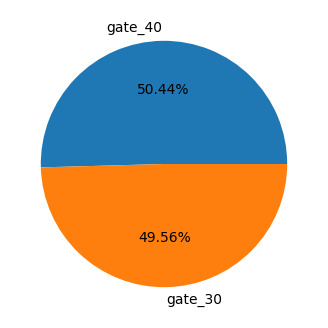

In [91]:
data_version = data.version.value_counts().reset_index() \
    .rename(columns={'index': 'gate'})

plt.figure(figsize=(4,4))
plt.pie(x=data_version.version, labels=data_version.gate, autopct='%.2f%%')
plt.show()

Видно, что размеры практически совпадают.

Теперь посмотрим на распределение наших данных по sum_gamerounds. Поищем выбросы и, возможно, какие-нибудь закономерности.

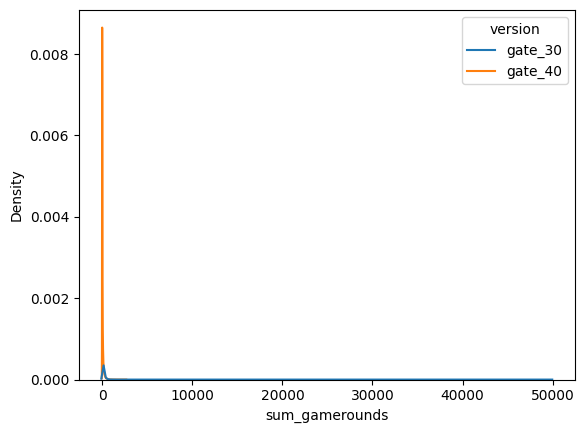

In [92]:
sns.kdeplot(x = 'sum_gamerounds' , data = data , hue = 'version')
plt.show()

Что-то не так с этим графиком.


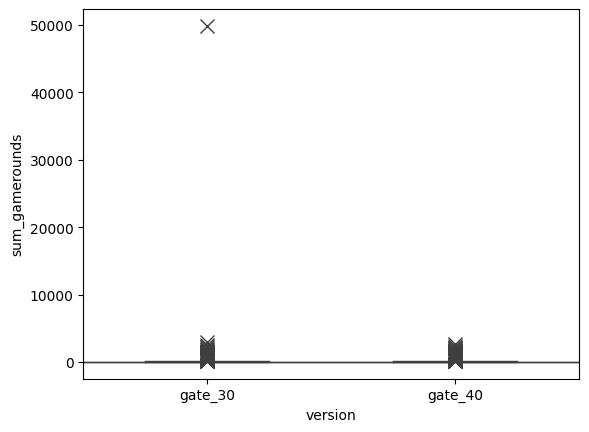

In [93]:
sns.boxplot(data=data,
            x="version",
            y="sum_gamerounds",
            flierprops={"marker": "x"},
            width=1.0, fliersize=10);

Видно, что в контрольной группе gate_30 есть очень значительный выброс. Видимо, это наше максимальное значение. Проверим это.

In [94]:
data.sort_values('sum_gamerounds', ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True


Действительно, имеем аномально большое значение у userid = 63900605. Уберём его из наших данных.

In [95]:
data = data[data['sum_gamerounds'] != max(data['sum_gamerounds'])]
data.userid.nunique()

90188

Построим распределение по sum_gamerounds ещё раз.

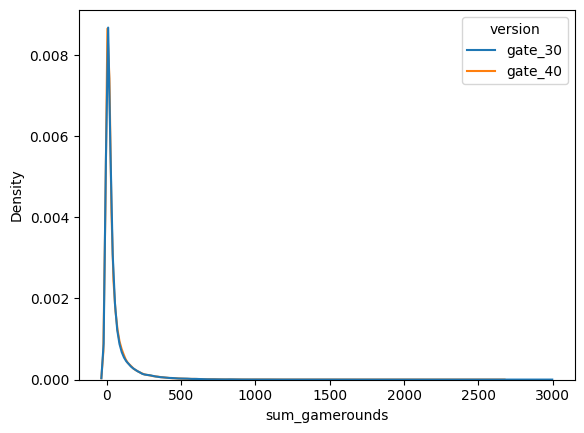

In [96]:
sns.kdeplot(x = 'sum_gamerounds' , data = data , hue = 'version')
plt.show()

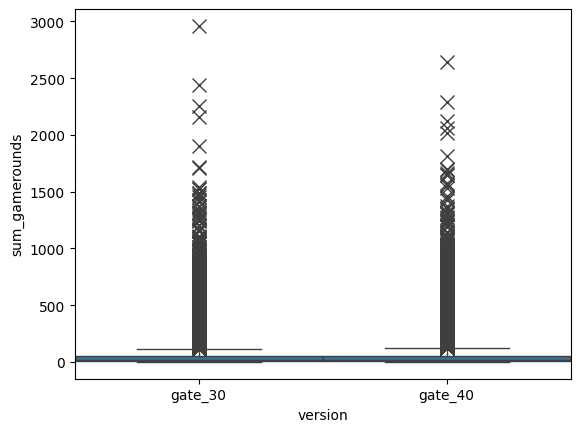

In [97]:
sns.boxplot(data=data,
            x="version",
            y="sum_gamerounds",
            flierprops={"marker": "x"},
            width=1.0, fliersize=10);

Хоть мы и имеем очень большие значения, но пока нет причин от них избавляться.

Теперь посмотрим на распределение игроков по количество пройденных уровней.

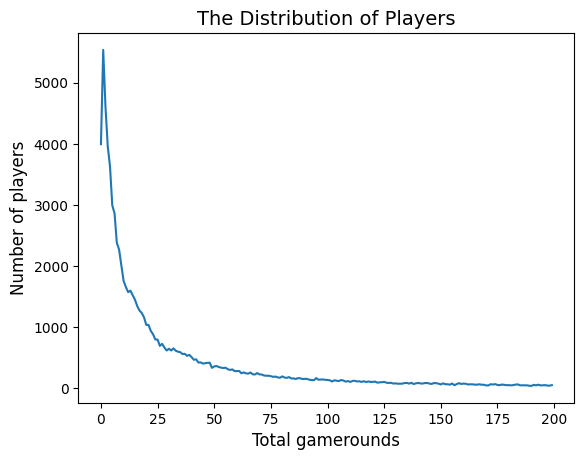

In [98]:
data_plot = data.groupby('sum_gamerounds')['userid'].count()

ax = data_plot.head(200).plot()
plt.title("The Distribution of Players", size=14)
plt.xlabel('Total gamerounds', size=12)
plt.ylabel('Number of players', size=12)
plt.show()

Видно, что значительная часть игроков имеет 0 пройденных уровней. Узнаем, сколько их.

In [99]:
num_players_zero = data.query("sum_gamerounds == 0").userid.count()
num_players_zero

3994

In [100]:
print(f"{round(num_players_zero / data.userid.nunique() * 100, 2)}%")

4.43%


Видно, что 3994 игрока или 4.43% от общего количества игроков скачали мобильную игру, но не прошли не одно раунда.

Распространенным показателем в индустрии видеоигр, показывающим, насколько увлекательна игра, является retention: процент игроков, которые возвращаются и играют в игру через 1 день и 7 дней после ее установки. Чем выше показатель retention, тем легче удерживать игроков и создавать большую базу игроков.

В качестве первого шага давайте посмотрим, что такое 1-day и 7-days retention в целом.

In [101]:
data_retention = round(data[['retention_1', 'retention_7']].mean() * 100, 2)
data_retention

retention_1    44.52
retention_7    18.61
dtype: float64

Меньше половины игроков возвращаются через 1 день. Меньше одной пятой вызвращаются через 7 дней.

Теперь посмотрим на различие retention в двух группах.

In [102]:
data.groupby('version', as_index=False) \
    .agg({'userid': 'count',
          'retention_1': 'mean',
          'retention_7': 'mean',
          'sum_gamerounds': 'sum'}) \
    .rename(columns={'userid': 'user_count',
                     'retention_1': 'retention_1_mean',
                     'retention_7': 'retention_7_mean'})

,version,user_count,retention_1_mean,retention_7_mean,sum_gamerounds
0,gate_30,44699,0.448198,0.190183,2294941
1,gate_40,45489,0.442283,0.182000,2333530


* Наблюдалось небольшое снижение 1-day retention, когда ворота были перемещены на уровень 40 (44,2%), по сравнению с контрольной группой, когда они находились на уровне 30 (44,8%).

* Опять же, снижение 7-days retention, когда ворота были перемещены на уровень 40 (18,2%), по сравнению с контрольной группой, когда они были на уровне 30 (19,0%).

* Это небольшое изменение, но даже небольшие изменения в retention могут иметь большое значение. Но хотя мы уверены в разнице данных, насколько мы должны быть уверены в том, что ворота на уровне 40 в будущем будут хуже?

Разделим на контрольную и тестовую группы.

In [103]:
control_group = data.loc[data['version'] == 'gate_30']
test_group = data.loc[data['version'] == 'gate_40']

## 4. A/B-тестирование для sum_gamerounds

Для начала подберём критерий: параметрический или непараметрический. Для этого проверим наши данные на нормальность и гомогенность дисперсий.

### 4.1. Проверка на распределения данных на нормальность и гомогенность дисперсии



Проведём тест Шапиро-Уилка:

* Нулевая гипотеза: Данные распределны нормально

* Альтернативная гипотеза: Данные распределны  ненормально

In [104]:
stat_control, pvalue_control = stats.shapiro(control_group['sum_gamerounds'])
stat_test, pvalue_test = stats.shapiro(test_group['sum_gamerounds'])

print("Control Group:\t Stat: {:.4f} Pvalue: {:.4f}".format(stat_control, pvalue_control))
print("Test Group:\t Stat: {:.4f} Pvalue: {:.4f}".format(stat_test, pvalue_test))

Control Group:	 Stat: 0.4886 Pvalue: 0.0000
Test Group:	 Stat: 0.4826 Pvalue: 0.0000


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Проведём тест Левена:

* Нулевая гипотеза: Дисперсии гомогенны

* Альтернативная гипотеза: Дисперсии не гомогенны

In [105]:
stat, pvalue = stats.levene(control_group['sum_gamerounds'], test_group['sum_gamerounds'])

print("Stat: {:.4f} Pvalue: {:.4f}".format(stat, pvalue))

Stat: 0.0751 Pvalue: 0.7840


Видно, что на уровне 0.05 нулевая гипотеза о нормальности распределения данных отклоняется (нулевую гипотезу о гомогенности дисперсий не отклоняем).

Значит, будем применять непараметрический критерий - критерий Манна-Уитни.

### 4.2. Критерий Манна-Уитни

In [106]:
stat, pvalue = stats.mannwhitneyu(control_group['sum_gamerounds'], test_group['sum_gamerounds'])

print("Stat: {:.4f} Pvalue: {:.4f}".format(stat, pvalue))

Stat: 1024285761.5000 Pvalue: 0.0509


Видно, что на уровне 0.05 отклонить нулевую гипотезу не можем и статистической значимости нет.

## 5. A/B-тестирование для retention

* Нулевая гипотеза: средние в группах совпадают

* Альтернативная гипотеза: средние в группах не совпадают

### 5.1. Z-тест

$\omega_1, \omega_2 - средние\ в\ группах $

$\bar{x}_1, \bar{x}_2 - средние\ в\ выборках $

$S^2_1, S^2_2 - выборочные\ дисперсии $

$n_1, n_2 - количество\ наблюдений\ в\ группе $

$H_0: \omega_1 = \omega_2 $

$H_1: \omega_1 <> \omega_2 $

Z-статистика:

$$ z = \frac{(\bar{x}_1 - \bar{x}_2) - (\omega_1 - \omega_2)}{\sqrt{\frac{S^2_1}{n_1} + \frac{S^2_2}{n_2}}} $$

In [107]:
def z_test(group_1, group_2):
    mean_1, mean_2 = np.mean(group_1), np.mean(group_2)
    var_1, var_2 = np.var(group_1), np.var(group_2)
    n_1, n_2 = len(group_1), len(group_2)

    z_score = (mean_1 - mean_2) / np.sqrt((var_1 / n_1) + (var_2 / n_2))
    p_value = stats.norm.cdf(z_score)

    if z_score > 0:
        p_value = 2 * (1 - p_value)
    else:
        p_value *= 2

    return z_score, p_value

In [108]:
stat_z_1, pvalue_z_1 = z_test(control_group['retention_1'], test_group['retention_1'])
stat_z_7, pvalue_z_7 = z_test(control_group['retention_7'], test_group['retention_7'])

print("Retention 1: Stat: {:.4f} Pvalue: {:.4f}".format(stat_z_1, pvalue_z_1))
print("Retention 7: Stat: {:.4f} Pvalue: {:.4f}".format(stat_z_7, pvalue_z_7))

Retention 1: Stat: 1.7871 Pvalue: 0.0739
Retention 7: Stat: 3.1571 Pvalue: 0.0016


На уровне 0.05 нельзя отклонить нулевую гипотезу в случае с 1-day retention, но можно отклонить в случае с 7-days retention. Таким образом, выбор расположения ворот даёт статистическую значимость для retention через 7 дней.

Поскольку после перемещения ворот из 30 в 40 уровень, было снижение 7-days retention, то можно сказать, что лучший вариант - это оставить ворота на 30 уровне.

### 5.2. T-тест

In [109]:
stat_t_1, pvalue_t_1 = stats.ttest_ind(control_group['retention_1'], test_group['retention_1'])
stat_t_7, pvalue_t_7 = stats.ttest_ind(control_group['retention_7'], test_group['retention_7'])

print("Retention 1: Stat: {:.4f} Pvalue: {:.4f}".format(stat_t_1, pvalue_t_1))
print("Retention 7: Stat: {:.4f} Pvalue: {:.4f}".format(stat_t_7, pvalue_t_7))

Retention 1: Stat: 1.7871 Pvalue: 0.0739
Retention 7: Stat: 3.1575 Pvalue: 0.0016


Поскольку при больших размерах выборок t-распределение практически совпадает с нормальным, то именно из-за этого результаты T-теста совпадают с Z-тестом.

### 5.3. Bootstrap

Сделаем тоже само с помощью Bootstrap метода. Для этого возьмём из данных 1000 выборок для каждого случая.

In [110]:
boot_1day = []
boot_7day = []
NUM_SAMPLES = 1000

for i in range(NUM_SAMPLES):
    boot_1_mean = data.sample(frac=1, replace=True) \
        .groupby('version')['retention_1'].mean()
    boot_7_mean = data.sample(frac=1, replace=True) \
        .groupby('version')['retention_7'].mean()
    boot_1day.append(boot_1_mean)
    boot_7day.append(boot_7_mean)

boot_1day = pd.DataFrame(boot_1day)
boot_7day = pd.DataFrame(boot_7day)

Визуализируем распределния средних бустрапированных выборок для каждой группы и для каждого случая.

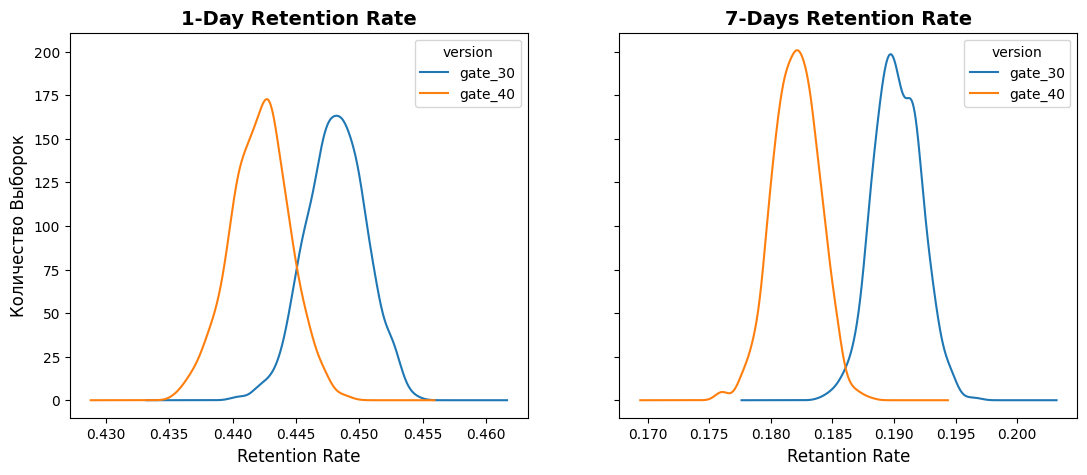

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1day.plot.kde(ax=ax1)
ax1.set_xlabel("Retention Rate",size=12)
ax1.set_ylabel("Количество Выборок",size=12)
ax1.set_title("1-Day Retention Rate", fontweight="bold",size=14)

boot_7day.plot.kde(ax=ax2)
ax2.set_xlabel("Retantion Rate",size=12)
ax2.set_title("7-Days Retention Rate", fontweight="bold",size=14)
plt.show()

Для удобства визуализируем относительную разность для каждого retention.

In [112]:
boot_1day['difference'] = ((boot_1day.gate_30 - boot_1day.gate_40) \
                           / boot_1day.gate_40 * 100)
boot_7day['difference'] = ((boot_7day.gate_30 - boot_7day.gate_40) \
                           / boot_7day.gate_40 * 100)

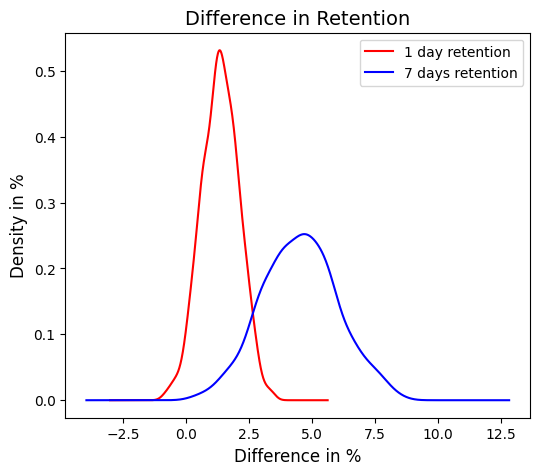

In [113]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

boot_1day['difference'].plot.kde(ax=ax1, c='red', label='1 day retention')
boot_7day['difference'].plot.kde(ax=ax1, c='blue', label='7 days retention')

ax1.set_xlabel('Difference in %', size=12)
ax1.set_ylabel('Density in %', size=12)
ax1.set_title('Difference in Retention', size=14)
plt.legend()
plt.show()

Изходя из графиков выше, можно сказать следующее:

* Относительная разность для 1-day retention составляет где-то 1% - 2%.

* Относительная разность для 7-days retention составляет где-то 2% - 7%.

* В пользу ворот на уровне 30 выступает также тот факт, что большая часть площади распределения больше 0.

Теперь для точного результат посчитаем вероятности того, что относительная разность больше 0.

In [114]:
prob_1day = (boot_1day['difference'] > 0).sum() / len(boot_1day['difference'])
prob_7day = (boot_7day['difference'] > 0).sum() / len(boot_7day['difference'])

print("1-day Retention:  {:.1f}%".format(prob_1day * 100))
print("7-days Retention: {:.1f}%".format(prob_7day * 100))

1-day Retention:  97.0%
7-days Retention: 100.0%


Видно, что с вероятностью 95.8% разность для 1-day retention будет больше 0 и с вероятностью 100.0% - для 7-days retention. По результатам работы с этими 2-мя метриками можно сказать, что уровень 30 лучше подходит для удержания игрока.

## 6. Выводы

После проведения исследования на этих данных можно сказать следующее:

1.   После переноса ворот с уровня 30 на уровенб 40 наблюдается снижение метрик 1-day retention (с 44.8% до 44.2%) и 7-days retention (с 19.0% до 18.2%).

2.   После проведения A/B тестирования для retention с использованием Z-теста, T-теста и Bootstrap метода получили, что 7-days retention выше для уровня 30. Про 1-day retention однозначно сказать нельзя, но Bootstrap показывает, что и в этом случае метрика выше.

3.   После проведения A/B тестирования для количества раундов с использованием критерия Манни-Уитни статистического значимости для этой метрики достигнутно не было.


Таким образом, уровень 30 лучше подходит для установки ворот.